In [1]:
import pandas as pd
import numpy as np
import json

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import sys
import os
sys.path.append(os.path.abspath('../'))
from tool import *

import matplotlib.pyplot as plt


data_root = '../../MyData/'

### Check similar_df and dissimilar_df

In [2]:
dissimilar_df = pd.read_csv(data_root + "dissimilar_pairs_2021.csv")
print(f"length of dissimilar_df: {len(dissimilar_df)}")
print(f"dissimilar_df columns: {dissimilar_df.columns}")
company_a_cik_set = set(dissimilar_df['company_a_cik'].unique())
company_b_cik_set = set(dissimilar_df['company_b_cik'].unique())
dissimilar_union_set = company_a_cik_set.union(company_b_cik_set)
print(f"number of firms occured in dissimilar_df: {len(dissimilar_union_set)} \n")

similar_df = pd.read_csv(data_root + "pairs_gpt_competitors_2021.csv")
print(f"length of similar_df: {len(similar_df)}")
print(f"dissimilar_df columns: {similar_df.columns}")
company_a_cik_set = set(similar_df['company_a_cik'].unique())
company_b_cik_set = set(similar_df['company_b_cik'].unique())
similar_union_set = company_a_cik_set.union(company_b_cik_set)
print(f"number of firms occured in similar_df: {len(similar_union_set)} \n")

print(f"final union set length: {len(dissimilar_union_set.union(similar_union_set))}")

# similar_df = similar_df[['company_a_cik', 'company_b_cik']]
# dissimilar_df = dissimilar_df[['company_a_cik', 'company_b_cik']]

length of dissimilar_df: 2913
dissimilar_df columns: Index(['Unnamed: 0', 'company_a_name', 'company_a_cik', 'company_a_products',
       'company_b_cik', 'company_b_name', 'company_b_tic',
       'company_b_products', 'reason_for_dissimilarity'],
      dtype='object')
number of firms occured in dissimilar_df: 1196 

length of similar_df: 2365
dissimilar_df columns: Index(['Unnamed: 0', 'company_a_name', 'company_a_cik', 'company_b_cik',
       'company_b_name', 'company_b_tic', 'competing_products'],
      dtype='object')
number of firms occured in similar_df: 1110 

final union set length: 1197


# Load data (With GICS_Sector)

In [3]:
new_embedding_df = pd.read_csv("./data/embedding_256.csv")
print(len(new_embedding_df))
new_embedding_df.head()

1197


,cik,tic,Year,GICS_Sector,item1_embeddings,SP_LONG_DESC_embeddings,SP_SHORT_DESC_embeddings,ORBIS_PROD_SERV_embeddings,ORBIS_OVERVIEW_embeddings
0,850460,WIRE,2021,20.0,"[-0.5898345708847046, 0.980162501335144, -0.96...","[-0.8353348970413208, 0.973402738571167, -0.98...","[-0.6867204904556274, 0.9938115477561951, -0.9...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ..."
1,352541,LNT,2021,55.0,"[0.9820889830589294, 0.4754180908203125, 0.869...","[0.9716767072677612, 0.7131884098052979, 0.879...","[0.9754056930541992, 0.2400549054145813, 0.895...","[0.972804069519043, 0.9935750365257263, 0.9685...","[0.8935458064079285, 0.9151054620742798, 0.755..."
2,1704715,AMR,2021,15.0,"[0.9945562481880188, -0.4087281823158264, 0.68...","[0.9718917012214661, -0.33507728576660156, 0.9...","[0.9910370111465454, -0.38968169689178467, 0.1...","[0.9949943423271179, -0.8197710514068604, 0.87...","[0.9967610239982605, -0.36475804448127747, 0.7..."
3,1575515,SFM,2021,30.0,"[-0.9608494639396667, -0.926054060459137, -0.9...","[-0.9911385178565979, -0.9708278775215149, -0....","[-0.9603582620620728, -0.9756494164466858, -0....","[-0.9450609087944031, -0.40782180428504944, -0...","[-0.13962775468826294, -0.8745130896568298, -0..."
4,1125376,ENSG,2021,35.0,"[-0.9341953992843628, -0.137389674782753, -0.9...","[-0.9762463569641113, -0.8669420480728149, -0....","[-0.8951124548912048, -0.10518676787614822, -0...","[0.1766112595796585, 0.7543022036552429, -0.99...","[-0.07263371348381042, 0.22911271452903748, -0..."


### Create a mapping

In [4]:
unique_cik = new_embedding_df['cik'].unique()

cik_to_index = {cik: idx for idx, cik in enumerate(unique_cik)}
index_to_cik = {idx: cik for idx, cik in enumerate(unique_cik)}

print("CIK to Index Mapping:", cik_to_index)

CIK to Index Mapping: {850460: 0, 352541: 1, 1704715: 2, 1575515: 3, 1125376: 4, 1674335: 5, 1023128: 6, 1262039: 7, 1122976: 8, 1128928: 9, 58492: 10, 40533: 11, 1370946: 12, 1469367: 13, 858655: 14, 1486159: 15, 70145: 16, 77476: 17, 1593034: 18, 1140536: 19, 1353283: 20, 912728: 21, 73309: 22, 1754301: 23, 882796: 24, 1309402: 25, 1524358: 26, 80424: 27, 1551182: 28, 1283699: 29, 1158172: 30, 8947: 31, 804328: 32, 1120370: 33, 1655075: 34, 1361658: 35, 40987: 36, 1320414: 37, 1584509: 38, 1466301: 39, 1552033: 40, 1281761: 41, 93410: 42, 76282: 43, 19584: 44, 723531: 45, 1530804: 46, 101984: 47, 910329: 48, 5513: 49, 31462: 50, 1338749: 51, 1409171: 52, 821026: 53, 817720: 54, 5272: 55, 1013871: 56, 1111928: 57, 1393818: 58, 66382: 59, 812011: 60, 730708: 61, 1672013: 62, 1109242: 63, 883945: 64, 1527166: 65, 1421461: 66, 355811: 67, 1262823: 68, 26058: 69, 14930: 70, 1637459: 71, 892553: 72, 1345016: 73, 844965: 74, 1318220: 75, 819793: 76, 1175454: 77, 936468: 78, 29989: 79, 35291

# Create dataset

### Prepare labels

In [5]:
# Get number of unique entities
N = len(unique_cik)

# Initialize the relation matrix with -1 (unknown/no relation)
relation_matrix = -1 * np.ones((N, N))

# Fill in similar pairs
for _, row in similar_df.iterrows():
    i, j = cik_to_index[row['company_a_cik']], cik_to_index[row['company_b_cik']]
    relation_matrix[i, j] = 1
    relation_matrix[j, i] = 1  # Ensure symmetry

# Fill in dissimilar pairs
for _, row in dissimilar_df.iterrows():
    i, j = cik_to_index[row['company_a_cik']], cik_to_index[row['company_b_cik']]
    relation_matrix[i, j] = 0
    relation_matrix[j, i] = 0  # Ensure symmetry

# Set diagonal to -1 (self-relations not needed)
np.fill_diagonal(relation_matrix, -1)

# Convert to PyTorch tensor
relation_matrix = torch.tensor(relation_matrix, dtype=torch.float32)

print("Relation Matrix:\n", relation_matrix)


# Count number of 1's
num_ones = (relation_matrix == 1).sum().item()

# Count number of -1's
num_neg_ones = (relation_matrix == 0).sum().item()

print(f"Number of 1's: {num_ones}")
print(f"Number of 0's: {num_neg_ones}")

Relation Matrix:
 tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])
Number of 1's: 4564
Number of 0's: 5826


#### **Some similar pairs are useless!**

In [6]:
print(len(similar_df))
print(len(dissimilar_df))
similar_df[similar_df['company_a_cik'] == similar_df['company_b_cik']]

2365
2913


,Unnamed: 0,company_a_name,company_a_cik,company_b_cik,company_b_name,company_b_tic,competing_products
70,70,ARROW ELECTRONICS INC,7536,7536,Arrow Electronics' Distribution Services,ARW,"Electronic components, supply chain management..."
80,80,AVERY DENNISON CORP,8818,8818,Avery Products Corporation,AVY,"Office supplies, Labels, Binders, Dividers"
134,134,BROWN FORMAN CORP,14693,14693,Brown-Forman Corp (CIK,BF.B,"Whiskey, Vodka, Liqueurs, Tequila"
170,170,CAVCO INDUSTRIES INC,278166,278166,"Cavco Industries, Inc. (and its subsidiaries)",CVCO,Manufactured and modular homes
240,240,MOLSON COORS BEVERAGE CO,24545,24545,Molson Coors Beverage Company,TAP,"Beer (including Miller Lite, Coors Light, and ..."
...,...,...,...,...,...,...,...
2285,2285,COWEN INC,1466538,1466538,Cowen and Company (Division of COWEN INC itself),COWN,"Investment banking, research, and sales"
2304,2304,PACIRA BIOSCIENCES INC,1396814,1396814,"Pacira BioSciences, Inc. (Note",PCRX,EXPAREL (bupivacaine liposome injectable suspe...
2308,2308,UNITED PARKS & RESORTS INC,1564902,1564902,"SeaWorld Entertainment, Inc.",SEAS,"Theme parks, Marine life parks, Water parks"
2311,2311,ARAMARK,1584509,1584509,Aramark Uniform Services,ARMK,Uniform rental and facility services


### Prepare features

In [7]:
target_list = ['item1_embeddings', 'SP_LONG_DESC_embeddings', 'SP_SHORT_DESC_embeddings', 'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings']
info_list = ['cik', 'tic', 'Year', 'GICS_Sector']

# Drop rows that don't have GICS label
exp_df = convert_to_array(new_embedding_df, info_list, target_list, 256, False)
print(type(exp_df))
print(exp_df.columns)
print(exp_df.shape, '\n')



# Check if the DataFrame follows the order in cik_to_index
expected_order = [cik for _, cik in sorted(index_to_cik.items())]  # Get ordered CIKs
actual_order = exp_df["cik"].tolist()  # Get CIKs from the DataFrame

# Compare the order
if actual_order == expected_order:
    print("The DataFrame follows the expected order.")
else:
    print("The DataFrame is not in the expected order.")



# Dictionary to store the stacked embeddings as PyTorch tensors
embedding_tensors = {}
for col in target_list:
    numpy_array = np.vstack(exp_df[col].values)  # Stack the column values
    embedding_tensors[col] = torch.tensor(numpy_array, dtype=torch.float32)  # Convert to tensor

<class 'pandas.core.frame.DataFrame'>
Index(['cik', 'tic', 'Year', 'GICS_Sector', 'item1_embeddings',
       'SP_LONG_DESC_embeddings', 'SP_SHORT_DESC_embeddings',
       'ORBIS_PROD_SERV_embeddings', 'ORBIS_OVERVIEW_embeddings'],
      dtype='object')
(1197, 9) 

The DataFrame follows the expected order.


In [8]:
'''
Calculate the average of embedding for every firm
'''
def average_tensors(tensor_dict):
    """
    Computes the element-wise average of 2D tensors in a dictionary, 
    while handling NaN values properly.
    
    :param tensor_dict: Dictionary where values are 2D tensors of the same shape
    :return: A 2D tensor with the averaged values
    """
    tensor_list = list(tensor_dict.values())  # Extract tensors
    
    # Stack tensors along a new dimension (shape: [num_tensors, rows, cols])
    stacked_tensors = torch.stack(tensor_list, dim=0)

    # Create a mask for valid (non-NaN) values
    valid_mask = ~torch.isnan(stacked_tensors)

    # Replace NaNs with 0 for summation
    stacked_tensors = torch.nan_to_num(stacked_tensors, nan=0.0)

    # Sum across all tensors (axis=0)
    summed_tensors = torch.sum(stacked_tensors, dim=0)

    # Count valid (non-NaN) values at each position
    valid_counts = valid_mask.sum(dim=0)

    # Avoid division by zero and compute the average
    average_tensor = summed_tensors / torch.clamp(valid_counts, min=1)

    return average_tensor

average_latent = average_tensors(embedding_tensors)

### Final step

In [9]:
# Define a custom dataset
class ContrastiveDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx], idx

print(average_latent.shape)
print(relation_matrix.shape)
dataset = ContrastiveDataset(average_latent, relation_matrix)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True)

torch.Size([1197, 256])
torch.Size([1197, 1197])


# Model training

In [10]:
# Define a simple model
class ProjectionNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ProjectionNet, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

# Define contrastive loss
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, z1, z2, labels):
        distances = torch.norm(z1 - z2, p=2, dim=1)
        loss = (labels * distances.pow(2)) + ((1 - labels) * torch.relu(self.margin - distances).pow(2))
        return loss.mean()

In [11]:
input_dim = 256
output_dim = 128

# Model, loss, and optimizer
model = ProjectionNet(input_dim, output_dim)
criterion = ContrastiveLoss(margin=1.0)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 300
for epoch in range(num_epochs):
    print(epoch)
    total_loss = 0
    for batch_data, batch_labels, idx in dataloader:

        batch_size = batch_data.size(0)
        shuffled_indices = torch.randperm(batch_size)

        z1 = model(batch_data)
        z2 = z1[shuffled_indices]
        shuffled_idx = idx[shuffled_indices]
        pair_labels = batch_labels[torch.arange(batch_size), shuffled_idx]

        # # =================================================
        # print(shuffled_indices)
        # print(z1)
        # print(z2,'\n')
        # print(idx)
        # print(shuffled_idx)

        # num_ones = (pair_labels == 1).sum().item()
        # num_neg_ones = (pair_labels == 0).sum().item()
        # print(f"Number of 1's: {num_ones}")
        # print(f"Number of 0's: {num_neg_ones}")
        # # =================================================

        # Filter out neutral pairs (if any)
        mask = pair_labels != -1
        if mask.any():  # Check if there's at least one valid pair
            z1 = z1[mask]
            z2 = z2[mask]
            pair_labels = pair_labels[mask]

            # Compute loss
            loss = criterion(z1, z2, pair_labels)
        else:
            # Use a dummy tensor with requires_grad=True to avoid backward errors
            loss = torch.tensor(0.0, device=z1.device, requires_grad=True)
        
        total_loss += loss.item()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

0
Epoch [1/300], Loss: 31.9632
1
Epoch [2/300], Loss: 17.4467
2
Epoch [3/300], Loss: 10.3029
3
Epoch [4/300], Loss: 29.3982
4
Epoch [5/300], Loss: 20.3536
5
Epoch [6/300], Loss: 26.8731
6
Epoch [7/300], Loss: 6.3344
7
Epoch [8/300], Loss: 44.1989
8
Epoch [9/300], Loss: 29.3465
9
Epoch [10/300], Loss: 14.2318
10
Epoch [11/300], Loss: 5.6495
11
Epoch [12/300], Loss: 35.4443
12
Epoch [13/300], Loss: 23.0970
13
Epoch [14/300], Loss: 14.8056
14
Epoch [15/300], Loss: 4.0334
15
Epoch [16/300], Loss: 28.8230
16
Epoch [17/300], Loss: 6.5847
17
Epoch [18/300], Loss: 16.2139
18
Epoch [19/300], Loss: 11.2216
19
Epoch [20/300], Loss: 6.3470
20
Epoch [21/300], Loss: 8.6662
21
Epoch [22/300], Loss: 6.5548
22
Epoch [23/300], Loss: 10.4077
23
Epoch [24/300], Loss: 23.7933
24
Epoch [25/300], Loss: 13.5377
25
Epoch [26/300], Loss: 8.6326
26
Epoch [27/300], Loss: 23.3441
27
Epoch [28/300], Loss: 6.8349
28
Epoch [29/300], Loss: 12.2882
29
Epoch [30/300], Loss: 11.7305
30
Epoch [31/300], Loss: 7.3883
31
Epo

In [12]:
model.eval()
with torch.no_grad():
    final_representation = model(average_latent)
final_representation.shape

torch.Size([1197, 128])

In [13]:
exp_df = exp_df[['cik', 'tic', 'Year']]
exp_df['cluster_10'] = cluster(final_representation, 10)
exp_df['cluster_100'] = cluster(final_representation, 100)
exp_df

Normalized Within-Cluster Sum of Squares (WCSS): 0.009196892517650735
Normalized Within-Cluster Sum of Squares (WCSS): 0.00647388185773577


,cik,tic,Year,cluster_10,cluster_100
0,850460,WIRE,2021,6,29
1,352541,LNT,2021,2,4
2,1704715,AMR,2021,5,39
3,1575515,SFM,2021,0,36
4,1125376,ENSG,2021,6,24
...,...,...,...,...,...
1192,1021860,NOV,2021,1,56
1193,1744489,DIS,2021,9,82
1194,1102112,PACW,2021,2,89
1195,28823,DBD,2021,1,7


In [14]:
year = 2021
mode = 'forward'  # Can be 'in-sample', 'forward', or 'backtest'
returns_long = pd.read_csv(data_root+"returns_long.csv")

exp_returns = pd.merge(exp_df, returns_long, on='tic', how='inner')

exp_intra_corrs_10 = intra_industry_correlations(exp_returns, "cluster_10")
exp_avg_intra_corr_10 = np.nanmean(list(exp_intra_corrs_10.values()))
print(exp_avg_intra_corr_10)

exp_intra_corrs_100 = intra_industry_correlations(exp_returns, "cluster_100")
exp_avg_intra_corr_100 = np.nanmean(list(exp_intra_corrs_100.values()))
print(exp_avg_intra_corr_100)

print(len(exp_returns['cik'].unique()))

0.3647872890375815
0.4335757241041225
1064


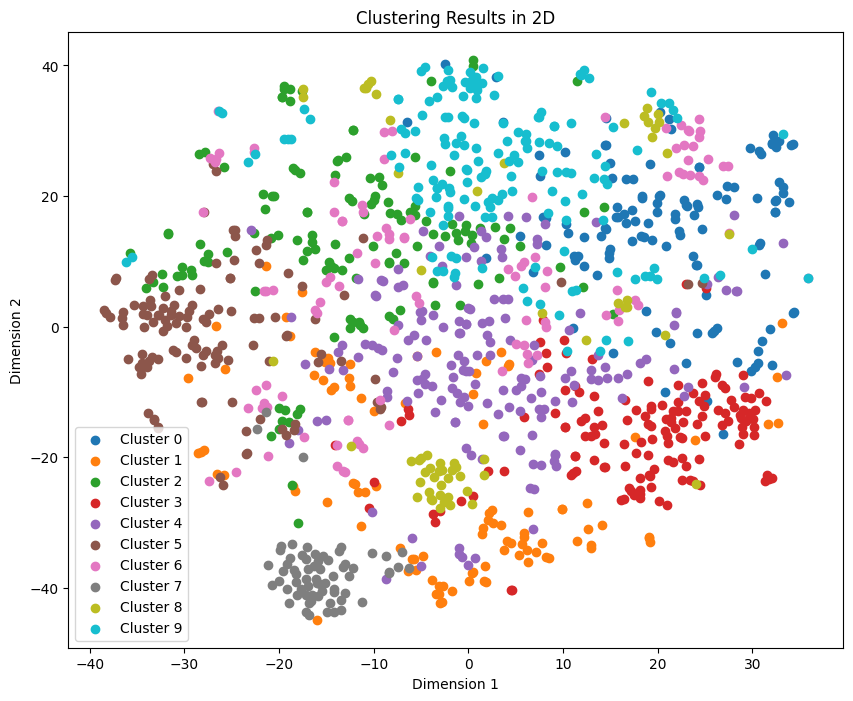

In [15]:
show_cluster_graph(final_representation, exp_df['cluster_10'])

# Pair eval

In [22]:
similar_df = pd.read_csv(data_root + "pairs_gpt_competitors_2021.csv")
similar_df = similar_df[similar_df['company_a_cik'] != similar_df['company_b_cik']]


In [23]:
exp_df.rename(columns={"cik": "CIK"}, inplace=True)
similar_df_results = precision_and_false_positive(similar_df, exp_df, ['cluster_10', 'cluster_100'], 10000)
similar_df_results

Missing CIKs in pairs dataset: 0 (company A), 0 (company B)
CIKs not found in main dataset: 0 (company A), 0 (company B)
Total valid pairs: 2282
77285
8910


,Classification_Scheme,Precision,False_Positive_rate,N_Industries,Avg_Firms_per_Industry
0,cluster_10,0.529360,0.984370,10,119.70
1,cluster_100,0.404908,0.896296,100,11.97


# Test

In [18]:
test = torch.tensor([[1, 2, 3, 4],
                    [5, 6, 7, 8],
                    [9, 10, 11, 12],
                    [13, 14, 15, 16]])
relation = torch.tensor([[1, 0, 1, 0],
                         [0, 1, 0, 1],
                         [1, 0, 1, 0],
                         [0, 1, 0, 1]])

shuffled_indices = torch.randperm(test.size(0))
print(shuffled_indices)

print(test)
print(test[shuffled_indices])

relation[torch.arange(test.size(0)), shuffled_indices]

tensor([3, 0, 2, 1])
tensor([[ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]])
tensor([[13, 14, 15, 16],
        [ 1,  2,  3,  4],
        [ 9, 10, 11, 12],
        [ 5,  6,  7,  8]])


tensor([0, 0, 1, 1])

In [152]:
target_tensor =  torch.tensor([[1, 2, 3, 4],
                               [5, 6, 7, 8],
                               [9, 10, 11, 12]])
target_tensor[[0, 1, 2], [0, 1, 2]]

tensor([ 1,  6, 11])